Work on making the mapping from PS to TESS automatic

In [7]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from schwimmbad import MultiPool
from glob import glob
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.path as pat
from tqdm import trange
from astropy.nddata import Cutout2D

from astropy.stats import SigmaClip
# from photutils import Background2D

import lightkurve as lk
from test_convolution import *

from scipy.ndimage import  rotate
from astropy.visualization import (SqrtStretch, ImageNormalize)
# Import the TESS PRF modelling from DAVE
import sys
sys.path
sys.path.append('./dave/diffimg/')
import tessprf as prf

In [2]:
def testRowFrac(datapath):        
    """Test that changing column fraction moves flux around"""

    obj = prf.TessPrf(datapath)
    
    img1 = obj.getPrfAtColRow(123.0, 456, 1,1,1)
    
    for frac in np.linspace(0, .9, 11):
        img2 = obj.getPrfAtColRow(123.0, 456.0 + frac, 1,1,1)
        delta = img2 - img1
        
        prfPlot(img1, delta)
        
        #For TESS, PRFs are 13x13. Check the flux near the centre
        #is moving from lower columns to higher ones
        assert delta[6,6] >= 0, delta[6,6]
        assert delta[7,6] >= 0, delta[7,6]
        assert delta[5,6] <= 0, delta[5,6]

        
def prfPlot(refImg, delta):
    
    kwargs = {'origin':'bottom', 'interpolation':'nearest', 'cmap':plt.cm.YlGnBu_r}
    plt.clf()
    plt.subplot(121)
    plt.imshow(refImg, **kwargs)
    plt.colorbar()

    plt.subplot(122)
    kwargs['cmap'] = plt.cm.PiYG
    plt.imshow(delta, **kwargs)  
    vm = max( np.fabs( [np.min(delta), np.max(delta)] ))
#        vm = 1e-2
    plt.clim(-vm, vm)
    plt.colorbar()
    plt.pause(.1)
    return
    
def Get_PRF(Row, Col, Cam, CCD, Sector = 1):
    pathToMatFile = './data/prf/'
    obj = prf.TessPrf(pathToMatFile)
    PRF = obj.getPrfAtColRow(Col, Row, CCD, Cam, Sector)
    return PRF
    
def Interp_PRF(Row, Column, Camera, CCD, Sector = 1):
    pathToMatFile = './data/prf/'
    obj = prf.TessPrf(pathToMatFile)
    PRF = obj.getPrfAtColRow(Column, Row, CCD,Camera, Sector)
    x2 = np.arange(0,PRF.shape[1]-1,0.01075)
    y2 = np.arange(0,PRF.shape[0]-1,0.01075)

    x = np.arange(0,PRF.shape[1],1)
    y = np.arange(0,PRF.shape[0],1)
    X, Y = np.meshgrid(x,y)

    x=X.ravel()              #Flat input into 1d vector
    y=Y.ravel()

    z = PRF
    z = z.ravel()
    x = list(x[np.isfinite(z)])
    y = list(y[np.isfinite(z)])
    z = list(z[np.isfinite(z)])

    znew = interpolate.griddata((x, y), z, (x2[None,:], y2[:,None]), method='cubic')
    kernal = znew
    return kernal

def Get_TESS_image(Path, Sector, Camera, CCD, Time = None):
    """
    Grabs a TESS FFI image from a directed path.
    Inputs
    ------
    Path: str
        Path to FFIs
    Sector: int
        Sector of the FFI
    Camera: int
        Camera of the FFI
    CCD: int
        CCD of the FFI
        
    Returns
    -------
    tess_image: array
        TESS image
    tess_wcs
        WCS of the TESS image
        
    Raises
    ------
    FileExistsError
        The file specified by the parameters does not exist.
        
    """
    if Time == None:
        File = "{Path}tess*-s{Sec:04d}-{Camera}-{CCD}*.fits".format(Path = Path, Sec = Sector, Camera = Camera, CCD = CCD)
    else:
        File = "{Path}tess{Time}-s{Sec:04d}-{Camera}-{CCD}*.fits".format(Path = Path, Time = Time, Sec = Sector, Camera = Camera, CCD = CCD)

    file = glob(File)
    if len(file) > 0:
        if (len(file) > 1):
            file = file[0]
        tess_hdu = fits.open(file)
        tess_wcs = WCS(tess_hdu[1].header)
        tess_image = tess_hdu[1].data
        return tess_image, tess_wcs
    else:
        raise FileExistsError("TESS file does not exist: '{}'".format(File))
        pass
        
        
pathToMatFile = './data/prf/'

def pix2coord(x, y, mywcs):
    """
    Calculates RA and DEC from the pixel coordinates
    """
    wx, wy = mywcs.all_pix2world(x, y, 1)
    return np.array([float(wx), float(wy)])

def coord2pix(x, y, mywcs):
    """
    Calculates RA and DEC from the pixel coordinates
    """
    wx, wy = mywcs.all_world2pix(x, y, 1)
    return np.array([float(wx), float(wy)])

In [41]:
def Get_TESS(RA,DEC,Size,Sector=None):
    c = SkyCoord(ra=float(RA)*u.degree, dec=float(DEC) *
                 u.degree, frame='icrs')
    
    tess = lk.search_tesscut(c,sector=Sector)
    tpf = tess.download(cutout_size=Size)
    
    return tpf

def Get_TESS_corners(TESS,PS1_wcs):
    x,y = TESS.flux.shape[1:]
    # include the top corners for the last pixels
    x += 1; y += 1

    corners = np.zeros((2,x,y))
    ps_corners = np.zeros((2,x,y))
    x_arr = np.arange(0,x)
    y_arr = np.arange(0,y)

    for i in range(x):
        for j in range(y):
            corners[:,i,j] = pix2coord(x_arr[i]-0.5,y_arr[j]-0.5,TESS.wcs)
            ps_corners[:,i,j] = coord2pix(corners[0,i,j],corners[1,i,j],PS1_wcs)
            
    return ps_corners

def Get_PS1(RA, DEC,Size, filt='i'):
    '''
    Size limit seems to be around 1000
    '''
    size = Size * 150 # last term is a fudge factor 
    fitsurl = geturl(RA,DEC, size=size, filters=filt, format="fits")
    if len(fitsurl) > 0:
        fh = fits.open(fitsurl[0])
        ps = fh[0].data
        ps_wcs = WCS(fh[0])
        return ps, ps_wcs
    else:
        raise ValueError("No PS1 images at for this coordinate") 
        return 
    
    
def ps2tessCts(ra, dec, size):
    #ps_x = image array in flux vals
    ps_g, wcs = Get_PS1(ra, dec, size, 'g')
    ps_i, wcs = Get_PS1(ra, dec, size, 'i')
    
    limiting_g = np.power(10, -(22 - 25)/2.5)
    limiting_i = np.power(10, -(21.5 - 25)/2.5)
    
    ps_g[ps_g <= 0] = limiting_g
    ps_i[ps_i <= 0] = limiting_i
    
    #Convert image to mags
    ps_g_mag = -2.5*np.log10(ps_g) + 25
    ps_i_mag = -2.5*np.log10(ps_i) + 25
    
    #Add together in accordance to https://arxiv.org/pdf/1706.00495.pdf pg.9
    #Calculate synthetic magnitude for TESS
    syn_tess_mag = (- 0.00206*np.power(ps_g_mag-ps_i_mag, 3) 
                    - 0.02370*np.power(ps_g_mag-ps_i_mag, 2) 
                    + 0.00573*(ps_g_mag-ps_i_mag) 
                    + ps_i_mag - 0.3078)
    #And now the flux
    syn_tess_cts = np.power(10, -(syn_tess_mag -20.44)/2.5)
    print(np.nanmean(syn_tess_mag))
    
    return syn_tess_cts, wcs

def Make_squares(Corners):
    squares = []
    for n in range(Corners.shape[1]-1):
        for m in range(Corners.shape[2]-1):
            # define the verticies
            square = np.zeros((4,2))
            square[0,:] = [Corners[0,n,m],Corners[1,n,m]]
            square[1,:] = [Corners[0,n+1,m],Corners[1,n+1,m]]
            square[2,:] = [Corners[0,n+1,m+1],Corners[1,n+1,m+1]]
            square[3,:] = [Corners[0,n,m+1],Corners[1,n,m+1]]
            # define the patch
            path = pat.Path(square)
            squares += [path]
    return squares

def Footprint_square(Corners, Points):
    square = np.zeros((4,2))
    square[0,:] = [Corners[0,0,0],Corners[1,0,0]]
    square[1,:] = [Corners[0,-1,0],Corners[1,-1,0]]
    square[2,:] = [Corners[0,-1,-1],Corners[1,-1,-1]]
    square[3,:] = [Corners[0,0,-1],Corners[1,0,-1]]
    path = pat.Path(square)
    contained = path.contains_points(Points)
    points = Points[contained] 
    return points
    
def Pix_sum(Square):
    arr = np.zeros_like(squares)
    contained = squares[Square].contains_points(pspixels)
    if contained.any():
        good = pspixels[contained].astype('int')
        summed = np.nansum(psimage[good[:,1],good[:,0]])
        arr[Square] = summed
    return arr

def Regrid_PS(PS1, Corners):
    dim1, dim2 = Corners.shape[1:]
    dim1 -= 1; dim2 -= 1
    global px, py
    px, py = np.where(PS1)
    global squares
    squares = np.array(Make_squares(Corners))
    square_num = np.arange(0,len(squares))

    points = np.zeros((len(px),2))
    points[:,0] = px
    points[:,1] = py

    global pspixels
    pspixels = Footprint_square(Corners, points)

    global psimage
    psimage = PS1.copy()
    
    pool = MultiPool()
    values = list(pool.map(Pix_sum, square_num))
    pool.close()

    PS_scene = np.array(values)
    PS_scene = np.nansum(PS_scene,axis=0)
    PS_scene = PS_scene.astype('float')
    PS_scene = PS_scene.reshape(dim1,dim2)
    return PS_scene

def Photutils_background(Flux):
    """
    Uses Photutils to estimate the background flux.
    
    Inputs:
    -------
    Flux - 3d array

    Outputs:
    -------
    bkg - background model
    std - rms error of the background model 

    """
    bkg = np.zeros_like(Flux)
    std = np.zeros_like(Flux)
    sigma_clip = SigmaClip(sigma=3.)
    #bkg_estimator = SExtractorBackground()
    beep = Background2D(Flux, (3, 3), sigma_clip=sigma_clip,exclude_percentile=70)
    bkg = beep.background
    std = beep.background_rms
    return bkg, std


def Make_TESS_scene(RA, DEC, Size, Convolve = 'PS1', Figures = False):
    tess = Get_TESS(RA,DEC,Size)
    
    PS1_image, PS1_wcs = ps2tessCts(RA,DEC,Size)
    
    if np.isnan(PS1_image).any():
        #bkg, = Photutils_background(PS1_image)
        print('PS1 image for the region is incomplete.'
               ' NaNs are present in image. NaN values are set to background value')
        PS1_image[np.isnan(PS1_image)] = 0#bkg
    
    if Convolve == 'PS1':
        try:
            kernal = Interp_PRF(tess.row + (Size/2), tess.column + (Size/2),
                                tess.camera, tess.ccd, tess.sector)
            PS1_image = signal.fftconvolve(PS1_image, kernal,mode='same')
        except MemoryError:
            raise MemoryError("The convolution is too large, try a smaller array.")
            
    tess_corners = Get_TESS_corners(tess, PS1_wcs)
    if Figures:
        plt.figure(figsize=(6,3))
        #plt.subplot(projection=ps_wcs)
        plt.subplot(1,2,1)
        plt.title('PS1 image')
        plt.imshow(PS1_image/np.nanmax(PS1_image),origin='lower',vmax=.1,cmap='Greys')
        x, y = tess.flux.shape[1:]
        x += 1; y += 1
        z = np.arange(0,x*y,1)
        plt.scatter(tess_corners[0,:,:].flatten(),tess_corners[1,:,:].flatten(),c=z,s=1)

        plt.subplot(1,2,2)
        plt.title('TESS image')
        plt.imshow(tess.flux[0]/np.nanmax(tess.flux[0]),origin='lower',vmax=.1)
    
    ps1_scene = Regrid_PS(PS1_image,tess_corners)
    
    if Convolve == 'Scene':
        PRF = Get_PRF(tess.row + (Size/2), tess.column + (Size/2),
                      tess.camera,tess.ccd, tess.sector)
        ps1_scene = signal.fftconvolve(ps1_scene, PRF, mode='same')
        
    if Figures:
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.title('PS1 scene')
        plt.imshow(rotate(np.flipud(ps1_scene/np.nanmax(ps1_scene)),-90),origin='lower',vmax=0.1)
        plt.subplot(1,2,2)
        plt.title('TESS image')
        plt.imshow(tess.flux[0]/np.nanmax(tess.flux[0]),origin='lower',vmax=0.1)
    
    return ps1_scene
    

In [ ]:
#ps_x = image array in flux vals

ra = 336
dec = 47
size = 2
ps_g, wcs = Get_PS1(ra, dec, size, 'g')
ps_i, wcs = Get_PS1(ra, dec, size, 'i')

#Convert image to mags
ps_g_mag = -2.5*np.log10(ps_g) + 25
ps_i_mag = -2.5*np.log10(ps_i) + 25


#Add together in accordance to https://arxiv.org/pdf/1706.00495.pdf pg.9
#Calculate synthetic magnitude for TESS
syn_tess_mag = (- 0.00206*np.power(ps_g_mag-ps_i_mag, 3) 
                - 0.02370*np.power(ps_g_mag-ps_i_mag, 2) 
                + 0.00573*(ps_g_mag-ps_i_mag) 
                + ps_i_mag - 0.3078)
#And now the flux
syn_tess_cts = np.power(10, -(syn_tess_mag -20.44)/2.5)
print(np.nanmean(syn_tess_mag))




# PS1_image, PS1_wcs = ps2tessCts(336, 47, 2)
# print(np.nanmin(PS1_image))
# plt.imshow(PS1_image)
# plt.colorbar()

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


20.488478


<IPython.core.display.Javascript object>


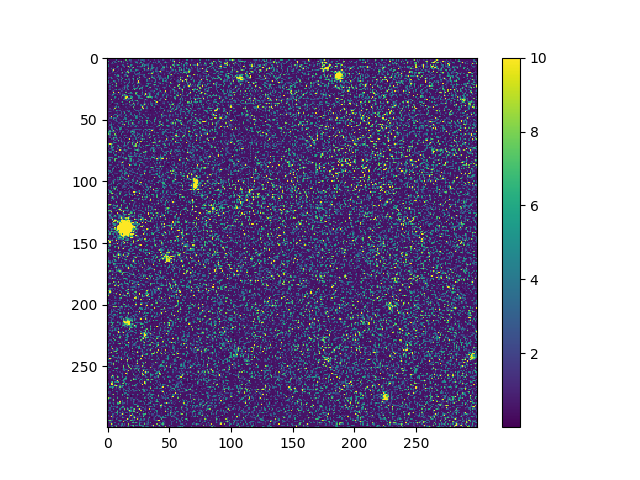

In [44]:
PS1_image, PS1_wcs = ps2tessCts(0, 0, 2)
plt.figure()
plt.imshow(PS1_image,vmax=10)
plt.colorbar()

In [7]:
tess = fits.open('data/tess2019255102927-s0016-1-1-0152-s_ffic.fits')
tess_image = tess[1].data
tess_wcs = WCS(tess[1])
pos = coord2pix(336,47,tess_wcs)
cut = Cutout2D(tess_image,(pos[0]-1,pos[1]-1),20,wcs=tess_wcs)

<IPython.core.display.Javascript object>


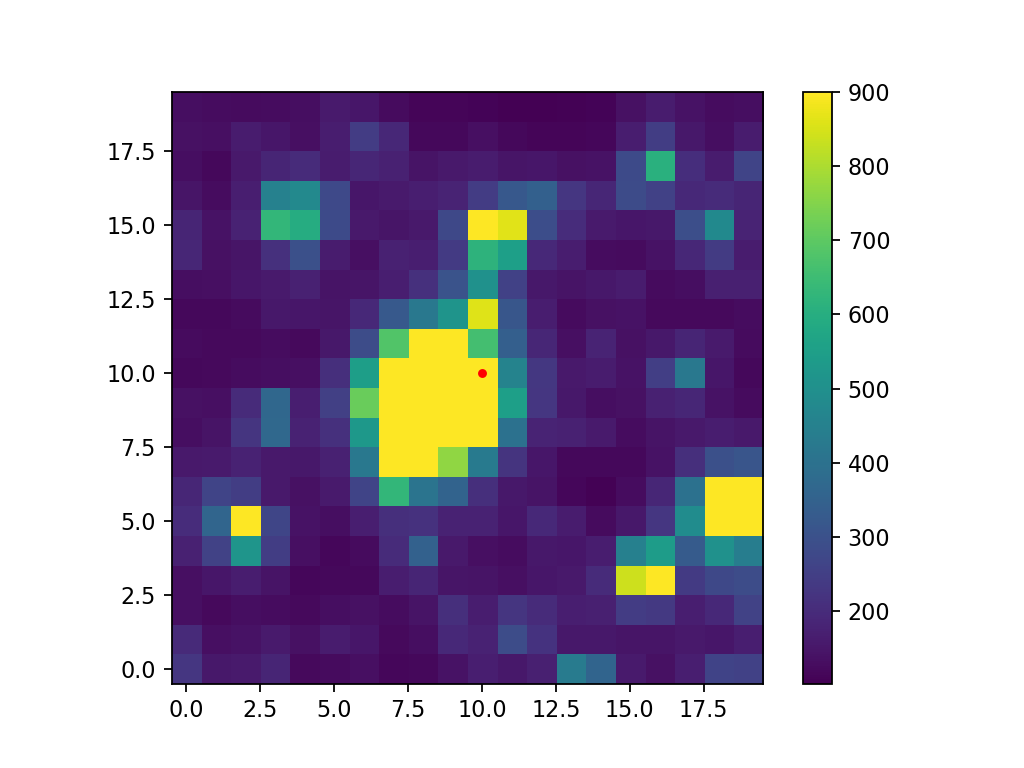

In [8]:
plt.figure()
plt.imshow(cut.data,origin='lower',vmax=900)
pos = coord2pix(336,47,cut.wcs)
plt.colorbar()
plt.plot(int(pos[0]),int(pos[1]),'r.')

In [10]:
size = 26*100
kernal = Interp_PRF(a.row + (x-1/2), a.column + (y-1/2),a.camera,a.ccd)
fitsurl = geturl(336,47, size=size, filters="i", format="fits")
if len(fitsurl) > 0:
    fh = fits.open(fitsurl[0])
    ps = fh[0].data
    ps_wcs = WCS(fh[0])
    ps = PS_nonan(ps)
    try:
        #Print_snapshot()
        test = signal.fftconvolve(ps, kernal,mode='same')
    except MemoryError:
        raise MemoryError("The convolution is too large, try a smaller array.")

NameError: name 'a' is not defined

<IPython.core.display.Javascript object>


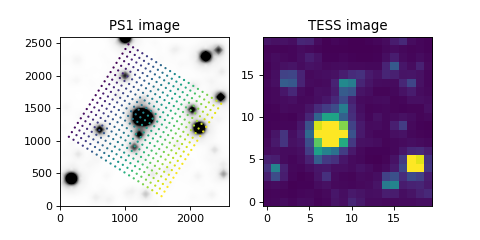

In [359]:
plt.figure(figsize=(6,3))
#plt.subplot(projection=ps_wcs)
plt.subplot(1,2,1)
plt.title('PS1 image')
plt.imshow(test/np.nanmax(test),origin='lower',vmax=.1,cmap='Greys')
z = np.arange(0,x*y,1)
plt.scatter(ps_corners[0,:,:].flatten(),ps_corners[1,:,:].flatten(),c=z,s=1)

plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(cut.data/np.nanmax(cut.data),origin='lower',vmax=.1)

#plt.savefig('TESS_pix_mapped_to_ps.pdf')

In [338]:
scene[0,0]

71250.945

In [13]:
scene = np.zeros_like(cut.data)

In [12]:
def Regrid_PS_serial(PS1, TESS, Corners):
    scene = np.zeros_like(TESS)
    px,py = np.where(PS1 > -1)
    points = np.zeros((len(px),2))
    points[:,0] = px
    points[:,1] = py

    for n in trange(scene.shape[0],leave=True):
        for m in range(scene.shape[1]):
            # define the verticies
            square = np.zeros((4,2))
            square[0,:] = [Corners[0,n,m],Corners[1,n,m]]
            square[1,:] = [Corners[0,n+1,m],Corners[1,n+1,m]]
            square[2,:] = [Corners[0,n+1,m+1],Corners[1,n+1,m+1]]
            square[3,:] = [Corners[0,n,m+1],Corners[1,n,m+1]]
            # define the patch
            path = pat.Path(square)
            # find all points inside the patch
            contained = path.contains_points(points)
            # summ up all points 
            if contained.any():
                summed = np.nansum(PS1[py[contained],px[contained]])
                scene[n,m] = summed
    return scene

In [14]:
scene = Regrid_PS(test,cut.data,ps_corners)

NameError: name 'test' is not defined

In [11]:
from scipy.ndimage import  rotate
from astropy.visualization import (SqrtStretch, ImageNormalize)

<IPython.core.display.Javascript object>


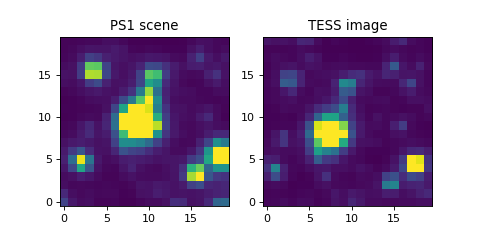

In [362]:
s = scene.copy()
s[s==0] = np.nan
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('PS1 scene')
plt.imshow(rotate(np.flipud(s/np.nanmax(s)),-90),origin='lower',vmax=0.1)
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(cut.data/np.nanmax(cut.data),origin='lower',vmax=0.1)
#plt.savefig('test_ps_to_tess.pdf')

In [480]:
np.where(test)

(array([   0,    0,    0, ..., 2599, 2599, 2599]),
 array([   0,    1,    2, ..., 2597, 2598, 2599]))

In [494]:
timestart = sys_time.time()
eh = Regrid_PS(ps,cut.data,ps_corners)
timestop = sys_time.time()
duration = timestop-timestart
print(duration)

50.593778133392334


In [493]:
duration

73.59766793251038

In [491]:
duration

41.56221413612366

In [477]:
squares = np.array(Make_squares(ps_corners))
square_num = np.arange(0,len(squares))
pool = MultiPool()
values = list(pool.map(Pix_sum, square_num))
pool.close()

PS_scene = np.array(values)
PS_scene = np.nansum(PS_scene,axis=0)
PS_scene = PS_scene.astype('float')

In [408]:
s = s.reshape(scene.shape)

In [436]:
cut.data.shape

(20, 20)

In [394]:
def Squares(Pixel, Corners, PS1, Points, Scene):
    n = Pixel[0]
    m = Pixel[1]
    
    square = np.zeros((4,2))
    square[0,:] = [Corners[0,n,m],Corners[1,n,m]]
    square[1,:] = [Corners[0,n+1,m],Corners[1,n+1,m]]
    square[2,:] = [Corners[0,n+1,m+1],Corners[1,n+1,m+1]]
    square[3,:] = [Corners[0,n,m+1],Corners[1,n,m+1]]
    
    if (square >= 0).any():
        # define the patch
        path = pat.Path(square)
        # find all points inside the patch
        contained = path.contains_points(points)
        # summ up all points 
        summed = np.nansum(PS1[px[contained],py[contained]])
        Scene[n,m] = summed
    return Scene

In [400]:
px,py = np.where(test > -1)
points = np.zeros((len(px),2))
points[:,0] = px
points[:,1] = py

scene = np.zeros_like(cut.data)
pix =np.array([0,0])

In [386]:
list(map(Squares, [pix],[ps_corners],[test],[points],[scene]))

[0 0]


[array([[278694.72,      0.  ,      0.  , ...,      0.  ,      0.  ,
              0.  ],
        [     0.  ,      0.  ,      0.  , ...,      0.  ,      0.  ,
              0.  ],
        [     0.  ,      0.  ,      0.  , ...,      0.  ,      0.  ,
              0.  ],
        ...,
        [     0.  ,      0.  ,      0.  , ...,      0.  ,      0.  ,
              0.  ],
        [     0.  ,      0.  ,      0.  , ...,      0.  ,      0.  ,
              0.  ],
        [     0.  ,      0.  ,      0.  , ...,      0.  ,      0.  ,
              0.  ]], dtype=float32)]

In [388]:
list(map(Regrid_PS, [test],[cut.data],[ps_corners]))

100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


[array([[1.87627375e+06, 1.10669688e+06, 4.18603531e+05, 3.58264375e+05,
         6.19333562e+05, 8.54285062e+05, 7.25060000e+05, 4.80513594e+05,
         2.78072906e+05, 2.02606516e+05, 1.36441000e+05, 1.48064031e+05,
         1.40656891e+05, 2.00887453e+05, 4.19889812e+05, 5.15754844e+05,
         3.65304500e+05, 2.34425938e+05, 2.04320547e+05, 1.82172969e+05],
        [6.35155312e+05, 4.23018312e+05, 2.76073469e+05, 4.88111688e+05,
         1.99479450e+06, 3.21955275e+06, 1.59214562e+06, 6.73510000e+05,
         3.68089656e+05, 2.56967906e+05, 1.68467766e+05, 1.47510766e+05,
         1.56172578e+05, 2.60656828e+05, 3.75447062e+05, 4.81882688e+05,
         4.63263125e+05, 3.51927375e+05, 2.64632625e+05, 2.11376766e+05],
        [3.74516125e+05, 3.18895375e+05, 2.90167469e+05, 8.29246500e+05,
         5.31759950e+06, 8.68504200e+06, 2.44077175e+06, 7.83730062e+05,
         7.07471312e+05, 6.01058812e+05, 2.76103812e+05, 1.96853656e+05,
         2.22756859e+05, 4.08260562e+05, 6.286732

In [395]:
pool = MultiPool()
values = list(pool.map(Squares, pix,[ps_corners],[test],[points],[scene]))
pool.close

TypeError: map() takes from 3 to 5 positional arguments but 7 were given

In [461]:
r = r.astype('float')

<IPython.core.display.Javascript object>


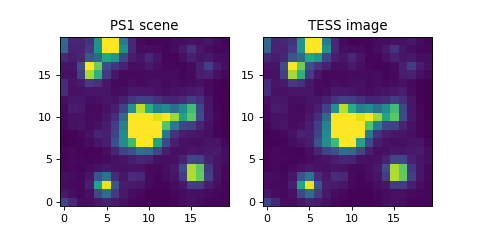

In [479]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('PS1 scene')
plt.imshow(PS_scene/np.nanmax(PS_scene),origin='lower',vmax=0.1)
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(scene/np.nanmax(scene),origin='lower',vmax=0.1)

In [184]:
points

array([[0.000e+00, 0.000e+00],
       [0.000e+00, 1.000e+00],
       [0.000e+00, 2.000e+00],
       ...,
       [4.999e+03, 4.997e+03],
       [4.999e+03, 4.998e+03],
       [4.999e+03, 4.999e+03]])

In [35]:
import time as sys_time

In [488]:
timestart = sys_time.time()


timestop = sys_time.time()
duration = timestop-timestart

In [489]:
duration

3.409385681152344e-05

In [509]:
corn = Get_TESS_corners(tpf,ps_wcs)

<IPython.core.display.Javascript object>


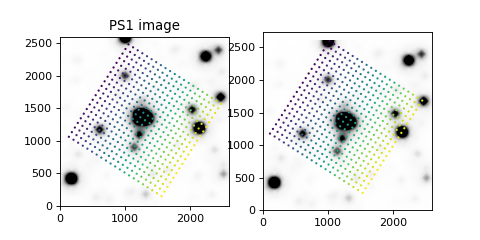

In [511]:
plt.figure(figsize=(6,3))
#plt.subplot(projection=ps_wcs)
plt.subplot(1,2,1)
plt.title('PS1 image')
plt.imshow(test/np.nanmax(test),origin='lower',vmax=.1,cmap='Greys')
z = np.arange(0,x*y,1)
plt.scatter(ps_corners[0,:,:].flatten(),ps_corners[1,:,:].flatten(),c=z,s=1)

plt.subplot(1,2,2)
plt.imshow(test/np.nanmax(test),origin='lower',vmax=.1,cmap='Greys')
z = np.arange(0,x*y,1)
plt.scatter(corn[0,:,:].flatten(),corn[1,:,:].flatten(),c=z,s=1)

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


PS1 image for the region is incomplete. NaNs are present in image. NaN values are set to background value


<IPython.core.display.Javascript object>


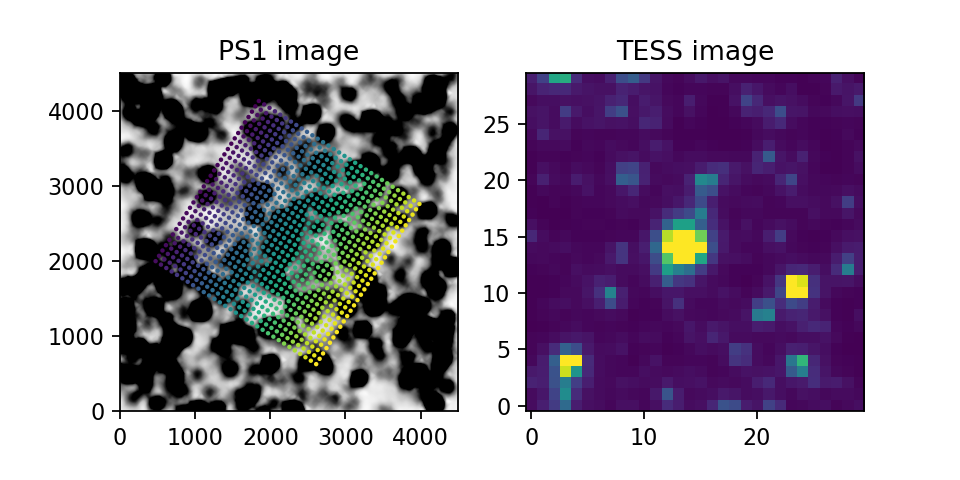

<IPython.core.display.Javascript object>


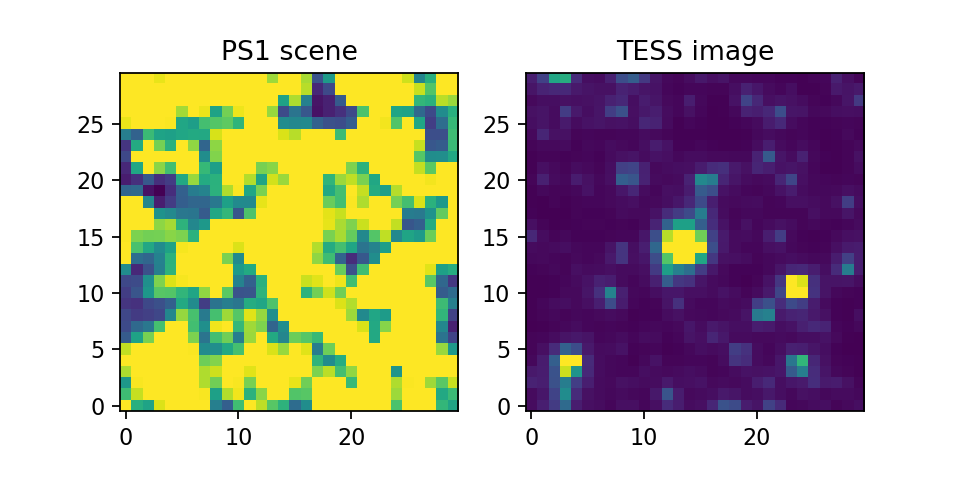

In [5]:
#timestart = sys_time.time()
test = Make_TESS_scene(336,47,30,Convolve='PS1',Figures=True)
#timestop = sys_time.time()
#duration = timestop-timestart
#print(duration)

In [20]:
tess = Get_TESS(336,47,20)

<IPython.core.display.Javascript object>


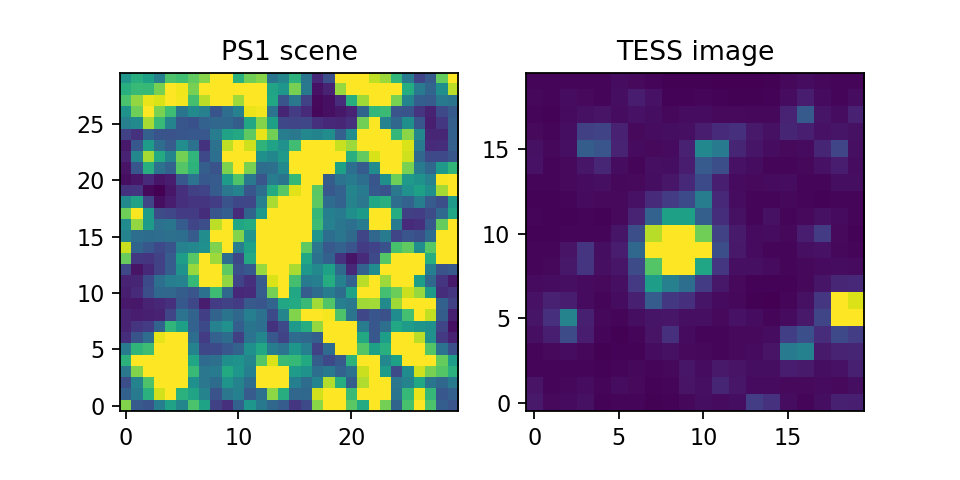

In [37]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('PS1 scene')
plt.imshow(rotate(np.flipud(test/np.nanmax(test)),-90),origin='lower',vmax=.)
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(tess.flux[0]/np.nanmax(tess.flux[0]),origin='lower',vmax=0.1)

In [39]:
ps1 = Get_PS1(336,47,30)

In [ ]:
plt.
plt.imsh

In [7]:
#np.save('tess.npy',tess.flux[0])
np.save('PS1_regrid.npy',test)

<IPython.core.display.Javascript object>


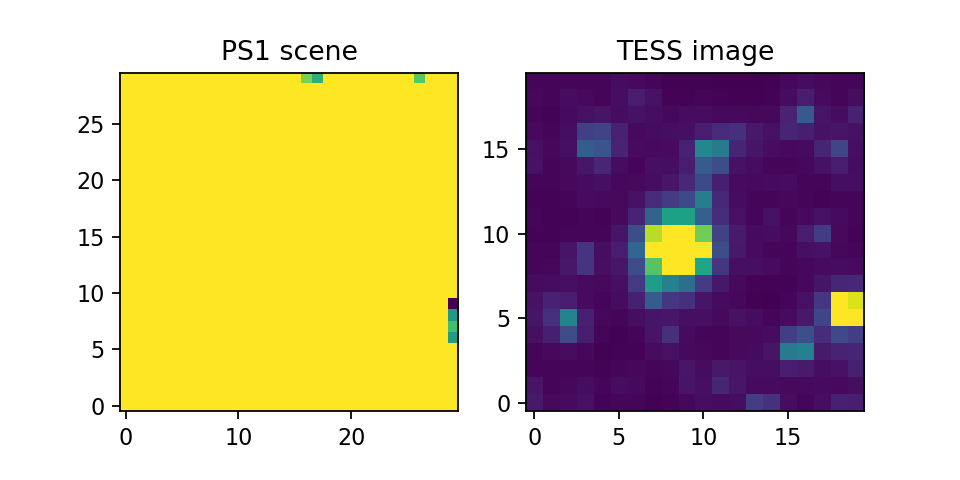

In [31]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('PS1 scene')
plt.imshow(rotate(np.flipud(test/np.nanmax(test)),-90),origin='lower',vmax=0.1)
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(tess.flux[0]/np.nanmax(tess.flux[0]),origin='lower',vmax=0.1)

<IPython.core.display.Javascript object>


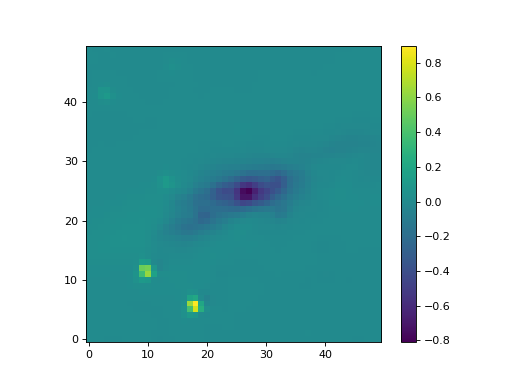

In [42]:
plt.figure()
plt.imshow((tess.flux[0]/np.nanmax(tess.flux[0])) - (rotate(np.flipud(test/np.nanmax(test)),-90)),origin='lower')
plt.colorbar()

<IPython.core.display.Javascript object>


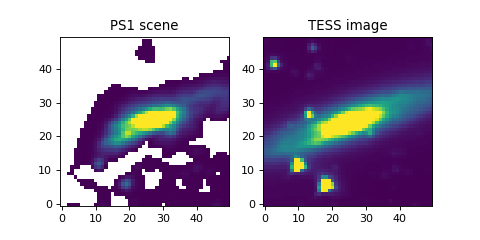

In [67]:
beep = test.copy()
beep = beep/np.nanmax(beep)
beep = rotate(np.flipud(beep),-90)
beep[beep < 1e-4] = np.nan
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('PS1 scene')
plt.imshow(beep,origin='lower',vmax=0.4)
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(tess.flux[0]/np.nanmax(tess.flux[0]),origin='lower',vmax=0.1)

array([[ 2.35452500e+06,  7.50731064e+05,  4.24923868e+04, ...,
         1.88501503e+02,  5.49589780e+01,  2.52305652e+01],
       [ 6.99029716e+06,  1.64758714e+06, -8.45983398e+05, ...,
         2.69430156e+02,  8.32572519e+01, -3.36667437e+01],
       [ 2.61808942e+07,  4.54074970e+06, -4.51466948e+06, ...,
         3.35956639e+02,  1.18616439e+02, -7.05772156e+01],
       ...,
       [ 9.19716563e+08,  4.25400320e+08,  2.40303488e+08, ...,
        -8.13126919e+05, -1.39783486e+05, -5.05526402e+02],
       [ 1.87421083e+08,  2.49596270e+08,  2.46053282e+08, ...,
         1.21346190e+06,  1.49131538e+04, -5.22649764e+02],
       [ 1.75171272e+08,  2.18495400e+08,  1.86352602e+08, ...,
         9.63882088e+05, -5.78349918e+02, -5.75547499e+02]])

In [64]:
np.where(beep < 1e-3)

(array([ 0,  0,  0, ..., 49, 49, 49]), array([ 0,  1,  2, ..., 47, 48, 49]))

In [62]:
beep

array([[ 1.44731155e-05,  4.61469613e-06,  2.61198000e-07, ...,
         1.15870676e-09,  3.37829344e-10,  1.55090681e-10],
       [ 4.29689123e-05,  1.01276134e-05, -5.20020617e-06, ...,
         1.65617004e-09,  5.11777035e-10, -2.06947334e-10],
       [ 1.60932292e-04,  2.79116998e-05, -2.77513863e-05, ...,
         2.06510410e-09,  7.29127712e-10, -4.33833658e-10],
       ...,
       [ 5.65343925e-03,  2.61490873e-03,  1.47713027e-03, ...,
        -4.99823949e-06, -8.59240202e-07, -3.10743866e-09],
       [ 1.15206548e-03,  1.53425241e-03,  1.51247388e-03, ...,
         7.45907314e-06,  9.16702087e-08, -3.21269488e-09],
       [ 1.07676668e-03,  1.34307734e-03,  1.14549760e-03, ...,
         5.92492192e-06, -3.55508018e-09, -3.53785389e-09]])

HTTPError: HTTP Error 400: fitscut error